训练序列数：38


100%|██████████| 150/150 [00:32<00:00,  4.62it/s, Epoch=149, GRU loss=0.0034, LSTM loss=0.0034, MLP loss=0.0055, GRU test loss=0.0346, LSTM test loss=0.0518, MLP test loss=1.0426]


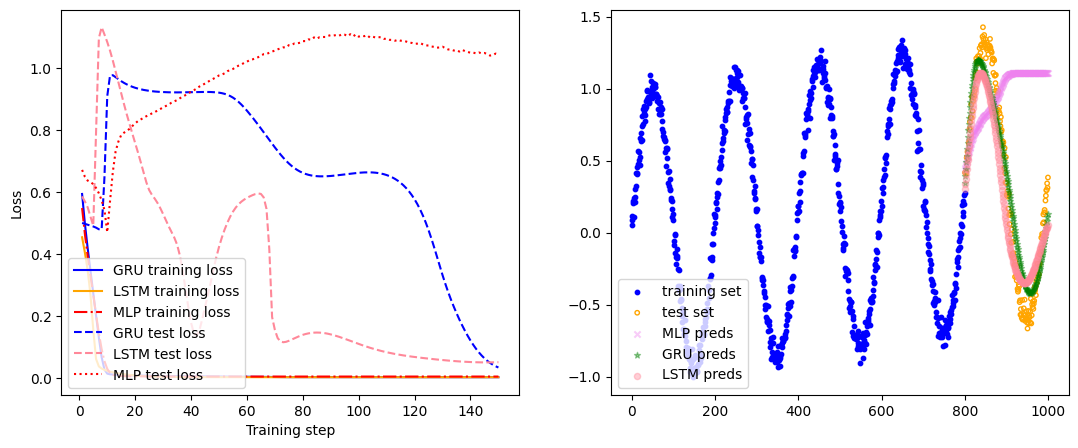

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

# 导入数据集
data = np.loadtxt('sindata_1000.csv', delimiter=',') # data的形状为一维的(num_data,)
num_data = len(data) # 1000
split = int(0.8 * num_data) # 强制转换为整数
# 分割数据集
train_data = np.array(data[:split])
test_data = np.array(data[split:])
# 输入序列长度
seq_len = 20
# 处理训练数据，把切分序列后多余的部分去掉
train_num = len(train_data) // (seq_len + 1) * (seq_len + 1) 
#用前seq_len个数据作为输入，后1个数据作为目标，故每个batch需要seq_len+1个数据
train_data = np.array(train_data[:train_num]).reshape(-1, seq_len + 1, 1) # 形状为(num_data, seq_len+1, 1)
# reshape函数三个参数为(行, 列, 高度)，其中行数用-1表示自动计算
# 本数据下，重塑后train_data的形状为三维数组(38,21,1)，总共38个序列，每个序列21个时间步，每个时间步1个输入 

# 指定随机种子
np.random.seed(0)
torch.manual_seed(0)

x_train = train_data[:, :seq_len] # 形状为(num_data, seq_len, input_size)
# :在列的位置，表示选择所有行
# :seq_len在行的位置，表示从下标0选择到下标seq_len-1
y_train = train_data[:, 1: seq_len + 1]
# 1:seq_len+1在行的位置，表示从下标1选择到下标seq_len
print(f'训练序列数：{len(x_train)}')

# 转为PyTorch张量
x_train = torch.from_numpy(x_train).to(torch.float32) # 从numpy转为PyTorch张量
y_train = torch.from_numpy(y_train).to(torch.float32)
x_test = torch.from_numpy(test_data[:-1]).to(torch.float32) # :-1表示除最后一个之外的全部
y_test = torch.from_numpy(test_data[1:]).to(torch.float32) # 1:表示除第一个之外的全部

class GRU(nn.Module):
    # 包含PyTorch的GRU和拼接的MLP
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        # GRU模块
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size) 
        # 将中间变量映射到预测输出的MLP
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size #补充书上有而代码无的hidden_size属性
        
    def forward(self, x, hidden):
        # 前向传播
        # x的维度为(batch_size, seq_len, input_size)
        # GRU模块接受的输入为(seq_len, batch_size, input_size)
        # 因此需要对x进行变换
        # transpose函数可以交换x的坐标轴
        # out的维度是(seq_len, batch_size, hidden_size)
        out, hidden = self.gru(torch.transpose(x, 0, 1), hidden) 
        # 取序列最后的中间变量输入给全连接层
        out = self.linear(out.view(-1, self.hidden_size)) #修改为self.hidden_size
        return out, hidden

class LSTM(nn.Module): #继承nn.Module，实现LSTM网络
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        # LSTM模块
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size) 
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        
    def forward(self, x, hidden):
        out, hidden = self.lstm(torch.transpose(x, 0, 1), hidden) 
        # LSTM相比GRU多了一个细胞状态，因此hidden是一个包含两个张量的元组
        out = self.linear(out.view(-1, self.hidden_size)) 
        return out, hidden
    
input_size = 1 # 输入维度
output_size = 1 # 输出维度
hidden_size = 16 # 中间变量维度
learning_rate = 5e-4

# 初始化网络
gru = GRU(input_size, output_size, hidden_size)
gru_optim = torch.optim.Adam(gru.parameters(), lr=learning_rate)

# GRU测试函数，x和hidden分别是初始的输入和中间变量
def test_gru(gru, x, hidden, pred_steps):
    pred = []
    inp = x.view(-1, input_size)
    for i in range(pred_steps):
        gru_pred, hidden = gru(inp, hidden)
        pred.append(gru_pred.detach())
        inp = gru_pred
    return torch.concat(pred).reshape(-1)

# 初始化LSTM网络和优化器
lstm = LSTM(input_size, output_size, hidden_size)
lstm_optim = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# LSTM测试函数
def test_lstm(lstm, x, hidden, pred_steps):
    pred = []
    inp = x.view(-1, input_size)
    # -1表示自动推断第一维度的维度数，第二个维度数为input_size
    for i in range(pred_steps):
        lstm_pred, hidden = lstm(inp, hidden)
        pred.append(lstm_pred.detach())
        inp = lstm_pred
    return torch.concat(pred).reshape(-1)

# MLP的超参数
hidden_1 = 32
hidden_2 = 16
mlp = nn.Sequential(
    nn.Linear(input_size, hidden_1),
    nn.ReLU(),
    nn.Linear(hidden_1, hidden_2),
    nn.ReLU(),
    nn.Linear(hidden_2, output_size)
)
mlp_optim = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# MLP测试函数，相比于GRU少了中间变量
def test_mlp(mlp, x, pred_steps):
    pred = []
    inp = x.view(-1, input_size)
    for i in range(pred_steps):
        mlp_pred = mlp(inp)
        pred.append(mlp_pred.detach())
        inp = mlp_pred
    return torch.concat(pred).reshape(-1)

max_epoch = 150
criterion = nn.functional.mse_loss

gru_losses = []
lstm_losses = []
mlp_losses = []
gru_test_losses = []
lstm_test_losses = []
mlp_test_losses = []

with tqdm(range(max_epoch)) as pbar:
    for epoch in pbar:
        gru_loss = 0.0
        lstm_loss = 0.0
        mlp_loss = 0.0

        # 初始化hidden
        gru_hidden = None
        lstm_hidden = None

        for X, y in zip(x_train, y_train):
            # zip函数可以把两个序列打包成一个元组序列
            # 每次循环返回一个元组，包含两个序列对应位置的元素，从而实现并行迭代

            # LSTM训练
            if lstm_hidden is not None:
                lstm_hidden = tuple(h.detach() for h in lstm_hidden)
                # lstm_hidden是一个包含两个张量的元组，需要分别分离
            lstm_pred, lstm_hidden = lstm(X[None, ...], lstm_hidden)
            lstm_train_loss = criterion(lstm_pred.view(y.shape), y)
            lstm_optim.zero_grad() # 清零梯度
            lstm_train_loss.backward() # 反向传播计算梯度
            lstm_optim.step() # 执行优化器的更新
            lstm_loss += lstm_train_loss.item() # 累计损失
            # .item()方法可以把只有一个元素的张量转为标量

            # GRU训练
            if gru_hidden is not None:
                gru_hidden = gru_hidden.detach()
            gru_pred, gru_hidden = gru(X[None, ...], gru_hidden)
            gru_train_loss = criterion(gru_pred.view(y.shape), y)
            gru_optim.zero_grad()
            gru_train_loss.backward()
            gru_optim.step()
            gru_loss += gru_train_loss.item()

            # MLP训练
            mlp_pred = mlp(X.view(-1, input_size))
            mlp_train_loss = criterion(mlp_pred.view(y.shape), y)
            mlp_optim.zero_grad()
            mlp_train_loss.backward()
            mlp_optim.step()
            mlp_loss += mlp_train_loss.item()

        gru_loss /= len(x_train)
        lstm_loss /= len(x_train)
        mlp_loss /= len(x_train)
        gru_losses.append(gru_loss)
        lstm_losses.append(lstm_loss)
        mlp_losses.append(mlp_loss)

        # 测试
        gru_pred = test_gru(gru, x_test[0], gru_hidden[:, -1] if gru_hidden is not None else None, len(y_test))
        
        # 测试时，取最后一个时间步的隐藏状态，去掉 batch 维
        lstm_h, lstm_c = lstm_hidden
        # 取最后一个样本（假设 batch_size=1），并 squeeze 去掉 batch 维
        lstm_h_test = lstm_h[:, -1, :].squeeze(1)  # [num_layers, hidden_size]
        lstm_c_test = lstm_c[:, -1, :].squeeze(1)  # [num_layers, hidden_size]
        # For unbatched input, hidden states should be 2-D
        lstm_pred = test_lstm(lstm, x_test[0], (lstm_h_test, lstm_c_test), len(y_test))
        mlp_pred = test_mlp(mlp, x_test[0], len(y_test))

        gru_test_loss = criterion(gru_pred, y_test).item()
        lstm_test_loss = criterion(lstm_pred, y_test).item()
        mlp_test_loss = criterion(mlp_pred, y_test).item()
        gru_test_losses.append(gru_test_loss)
        lstm_test_losses.append(lstm_test_loss)
        mlp_test_losses.append(mlp_test_loss)

        pbar.set_postfix({
            'Epoch': epoch,
            'GRU loss': f'{gru_loss:.4f}',
            'LSTM loss': f'{lstm_loss:.4f}',
            'MLP loss': f'{mlp_loss:.4f}',
            'GRU test loss': f'{gru_test_loss:.4f}',
            'LSTM test loss': f'{lstm_test_loss:.4f}',
            'MLP test loss': f'{mlp_test_loss:.4f}'
        })

# 最终测试结果
gru_preds = test_gru(gru, x_test[0], gru_hidden[:, -1] if gru_hidden is not None else None, len(y_test)).numpy()
# 测试时，取最后一个时间步的隐藏状态，去掉 batch 维

# LSTM测试
lstm_h, lstm_c = lstm_hidden
lstm_h_test = lstm_h[:, -1, :]  # [num_layers, hidden_size]
lstm_c_test = lstm_c[:, -1, :]  # [num_layers, hidden_size]
lstm_preds = test_lstm(lstm, x_test[0], (lstm_h_test, lstm_c_test), len(y_test)).numpy()

mlp_preds = test_mlp(mlp, x_test[0], len(y_test)).numpy()

# 绘图部分增加LSTM曲线
plt.figure(figsize=(13, 5))
plt.subplot(121)
x_plot = np.arange(len(gru_losses)) + 1
plt.plot(x_plot, gru_losses, color='blue', label='GRU training loss')
plt.plot(x_plot, lstm_losses, color='orange', label='LSTM training loss')
plt.plot(x_plot, mlp_losses, color='red', ls='-.', label='MLP training loss')
plt.plot(x_plot, gru_test_losses, color='blue', ls='--', label='GRU test loss')
plt.plot(x_plot, lstm_test_losses, color='#FF8899', ls='--', label='LSTM test loss')
plt.plot(x_plot, mlp_test_losses, color='red', ls=':', label='MLP test loss')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.legend(loc='lower left')

plt.subplot(122)
plt.scatter(np.arange(split), data[:split], color='blue', s=10, label='training set')
plt.scatter(np.arange(split, num_data), data[split:], color='none', edgecolor='orange', s=10, label='test set')
plt.scatter(np.arange(split, num_data - 1), mlp_preds, color='violet', marker='x', alpha=0.4, s=20, label='MLP preds')
plt.scatter(np.arange(split, num_data - 1), gru_preds, color='green', marker='*', alpha=0.4, s=20, label='GRU preds')
plt.scatter(np.arange(split, num_data - 1), lstm_preds, color='#FF8899', marker='o', alpha=0.4, s=20, label='LSTM preds')
plt.legend(loc='lower left')
plt.savefig('output_GRU_LSTM_MLP.png')
plt.savefig('output_GRU_LSTM_MLP.pdf')
plt.show()